# July 17 Progress Meeting

## Objective

The objective of this meeting is to go over the following:

1. LSTM results (sent previously in an email)
2. LSTM results adding population statistics
3. Population code: Discuss the following ideas
    - Copy the population value for that year into each month in the main dataset
    - Linearly interpolate the population to see how the results differ (haven't done yet)
4. Show transformer code and some results
5. Discuss path forward with transformer code
6. Discuss 290 or similar class
7. Discuss objectives for next meeting and set a date

## Code Demo

Below is a demo of the code, slightly modified to make for better use during presentation

In [27]:
import pandas as pd 
import torch.nn as nn 
import torch.optim as optim 
from models import LSTM, TransformerModel
from trainer import Trainer 
from data_utils import prep_data
from loss_functions import RMSELoss
from data_loader import combine_vf_fire_pop_data, combine_vf_wildfire_data
from transformer_modules.attention import MultiHeadAttention

def main(model_flag:str, county_name:str, bAdd_Pop:bool, epochs: int = 300, show_plot:bool = True ):

  fire_data_path       = "../data/CAL_FIRE_Wildland_PublicReport_2000to2018.csv"
  vf_data_path         = "../data/coccidioidomycosis_m2000_2015_v0.1.csv"
  pop1_data_path       = "../data/cali_county_pop_2000_2010.csv" 
  pop2_data_path       = "../data/cali_county_pop_2010_2020.csv"
  start_year           = "2006"
  end_year             = "2015"
  # county_name          = "Tulare"
  if bAdd_Pop:
    source_column_labels = ['Fire Incident Count', 'VF Case Count', 'Population']
  else:
    source_column_labels = ['Fire Incident Count', 'VF Case Count']
  
  split_frac           = .85
  lookback             = 6
  # input_size           = 3
  hidden_size          = 64
  num_layers           = 2
  dropout              = 0.2
  learning_rate        = 0.001
  # epochs               = 300
  weight_decay         = 1e-5
  if bAdd_Pop:
    title_text         = "(Population Added)"
  else:
    title_text         = "(Excl. Population)"
  # model_flag           = "transformer"

  # Transformer Properties
  if model_flag == "transformer":
    d_model         = 32
    nheads          = 2
    dim_feedforward = 64
    num_layers      = 1
    dropout         = 0.2

  if bAdd_Pop:
    df = combine_vf_fire_pop_data(pop1_data_path, pop2_data_path, vf_data_path, fire_data_path, county_name,
                                          start_year, end_year, bInterp=False)
    input_size = 3
  else:
    df = combine_vf_wildfire_data(fire_path=fire_data_path, vf_cases_path=vf_data_path, county_name=county_name)
    input_size = 2

  X_train, y_train, X_test, y_test, scaler = prep_data(df, source_column_labels, 
                                                        split_frac, lookback, b_scaler=True)

  # Able to be swapped out with other models (I hope)
  if model_flag == "lstm":
    model     = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
  elif model_flag == "transformer":
    model = TransformerModel(input_size= input_size, d_model = d_model, nhead= nheads, num_layers = num_layers,
                             dim_feedforward= dim_feedforward, dropout=dropout, attention_impl=MultiHeadAttention)
  else:
    raise NotImplementedError("Other Architectures besides LSTM and Transformer not implemented. " \
                              "If this is a mistake, check your spelling in model_flag variable.")
  criterion = RMSELoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)  

  trainer = Trainer(model = model, criterion = criterion, optimizer = optimizer, scaler = scaler)
  trainer.train(X_train, y_train, X_test, y_test, epochs)

  y_pred, y_true = trainer.evaluate(X_test, y_test)
  if show_plot:
    trainer.visualize_results(y_true, y_pred, county_name, model_type = model_flag, 
                            title_text = title_text, show_plot=True, save_fig = False)
  return y_pred, y_true

### LSTM Tests

#### Without Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2557, Testing Loss 0.0876
Epoch 11/300 - Training Loss 0.2051, Testing Loss 0.2362
Epoch 21/300 - Training Loss 0.1955, Testing Loss 0.1633
Epoch 31/300 - Training Loss 0.1889, Testing Loss 0.1782
Epoch 41/300 - Training Loss 0.1769, Testing Loss 0.1451
Epoch 51/300 - Training Loss 0.1631, Testing Loss 0.0983
Epoch 61/300 - Training Loss 0.1564, Testing Loss 0.0742
Epoch 71/300 - Training Loss 0.1482, Testing Loss 0.0906
Epoch 81/300 - Training Loss 0.1362, Testing Loss 0.0811
Epoch 91/300 - Training Loss 0.1262, Testing Loss 0.0872
Epoch 101/300 - Training Loss 0.1206, Testing Loss 0.0834
Epoch 111/300 - Training Loss 0.1129, Testing Loss 0.0909
Epoch 121/300 - Training Loss 0.1116, Testing Loss 0.0830
Epoch 131/300 - Training Loss 0.1119, Testing Loss 0.0799
Epoch 141/300 - Training Loss 0.1074, Testing Loss 0.0729
Epoch 151/300 - Training Loss 0.1043, Testing Loss 0.0793
Epoch 161/300 - Training Loss 0.0991, Testing Loss 0.0782
Epoch 171/300 - Training 

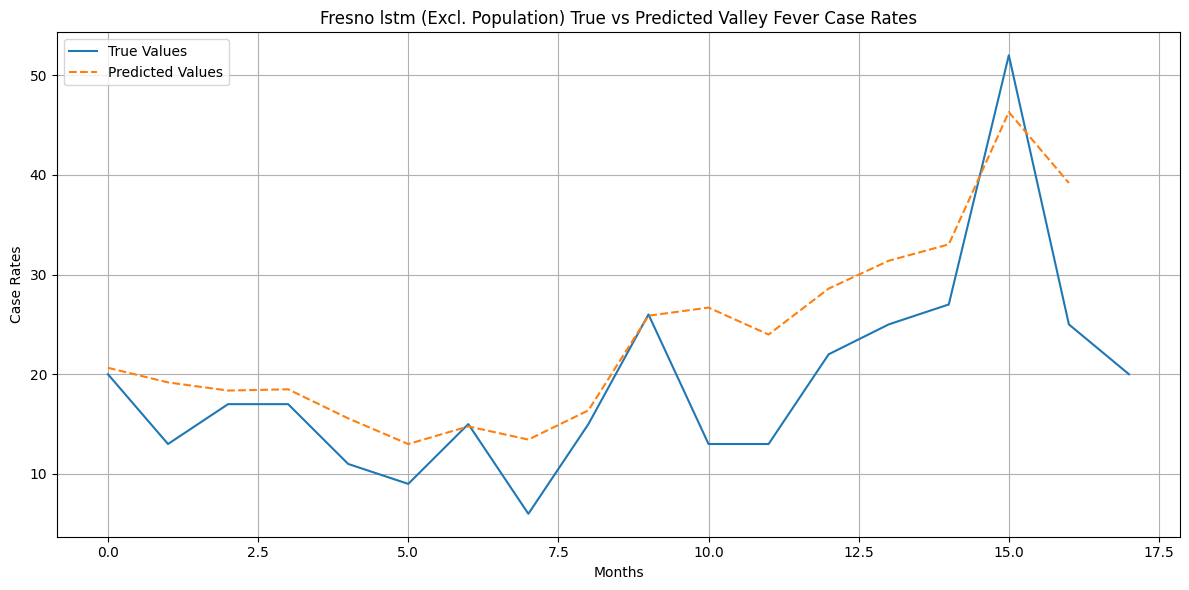

(array([16.72846209, 20.64505385, 19.18081588, 18.36323693, 18.48965359,
        15.57309204, 12.99600231, 14.76678416, 13.44504193, 16.37852841,
        25.87255803, 26.68657668, 23.98182669, 28.59263241, 31.38471186,
        33.02666777, 46.29756421, 39.18773961]),
 array([20.00000039, 13.0000002 , 16.99999959, 16.99999959, 10.99999981,
         8.99999989, 14.99999966,  6.        , 14.99999966, 25.99999925,
        13.0000002 , 13.0000002 , 21.9999994 , 25.00000021, 27.00000013,
        52.00000012, 25.00000021, 20.00000039]))

In [25]:
main(model_flag="lstm", county_name="Fresno", bAdd_Pop=False, epochs = 300)

#### With Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.3474, Testing Loss 0.1176
Epoch 11/300 - Training Loss 0.1999, Testing Loss 0.2349
Epoch 21/300 - Training Loss 0.1966, Testing Loss 0.1739
Epoch 31/300 - Training Loss 0.1917, Testing Loss 0.1574
Epoch 41/300 - Training Loss 0.1850, Testing Loss 0.1724
Epoch 51/300 - Training Loss 0.1738, Testing Loss 0.1244
Epoch 61/300 - Training Loss 0.1613, Testing Loss 0.0731
Epoch 71/300 - Training Loss 0.1553, Testing Loss 0.0621
Epoch 81/300 - Training Loss 0.1509, Testing Loss 0.0720
Epoch 91/300 - Training Loss 0.1391, Testing Loss 0.0668
Epoch 101/300 - Training Loss 0.1290, Testing Loss 0.0754
Epoch 111/300 - Training Loss 0.1246, Testing Loss 0.0843
Epoch 121/300 - Training Loss 0.1141, Testing Loss 0.0752
Epoch 131/300 - Training Loss 0.1103, Testing Loss 0.0822
Epoch 141/300 - Training Loss 0.1021, Testing Loss 0.0770
Epoch 151/300 - Training Loss 0.1074, Testing Loss 0.0803
Epoch 161/300 - Training Loss 0.1029, Testing Loss 0.0796
Epoch 171/300 - Training 

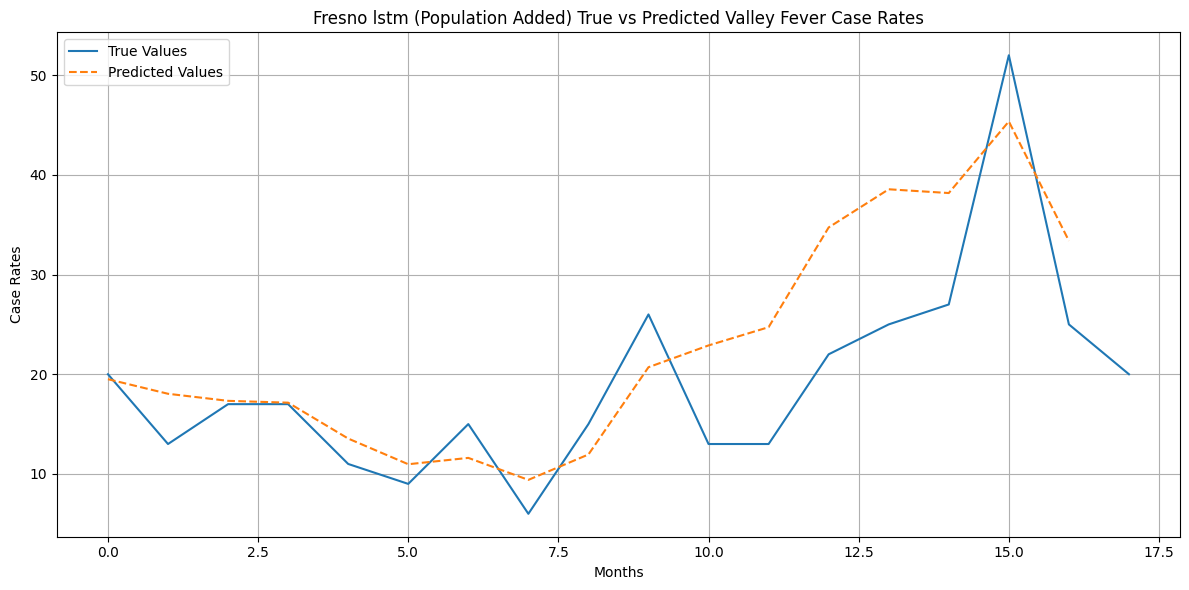

In [18]:
main(model_flag="lstm", county_name="Fresno", bAdd_Pop=True)

### Tranformer Model Tests (MultiHeadAttention)

#### Without Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4404, Testing Loss 0.0931
Epoch 11/300 - Training Loss 0.3588, Testing Loss 0.1409
Epoch 21/300 - Training Loss 0.2800, Testing Loss 0.2430
Epoch 31/300 - Training Loss 0.2483, Testing Loss 0.1461
Epoch 41/300 - Training Loss 0.2073, Testing Loss 0.1397
Epoch 51/300 - Training Loss 0.2067, Testing Loss 0.1469
Epoch 61/300 - Training Loss 0.2093, Testing Loss 0.1302
Epoch 71/300 - Training Loss 0.1749, Testing Loss 0.1309
Epoch 81/300 - Training Loss 0.1760, Testing Loss 0.1099
Epoch 91/300 - Training Loss 0.1669, Testing Loss 0.1026
Epoch 101/300 - Training Loss 0.1517, Testing Loss 0.0895
Epoch 111/300 - Training Loss 0.1685, Testing Loss 0.0844
Epoch 121/300 - Training Loss 0.1600, Testing Loss 0.0938
Epoch 131/300 - Training Loss 0.1408, Testing Loss 0.0735
Epoch 141/300 - Training Loss 0.1364, Testing Loss 0.0703
Epoch 151/300 - Training Loss 0.1422, Testing Loss 0.0771
Epoch 161/300 - Training Loss 0.1457, Testing Loss 0.0859
Epoch 171/300 - Training 

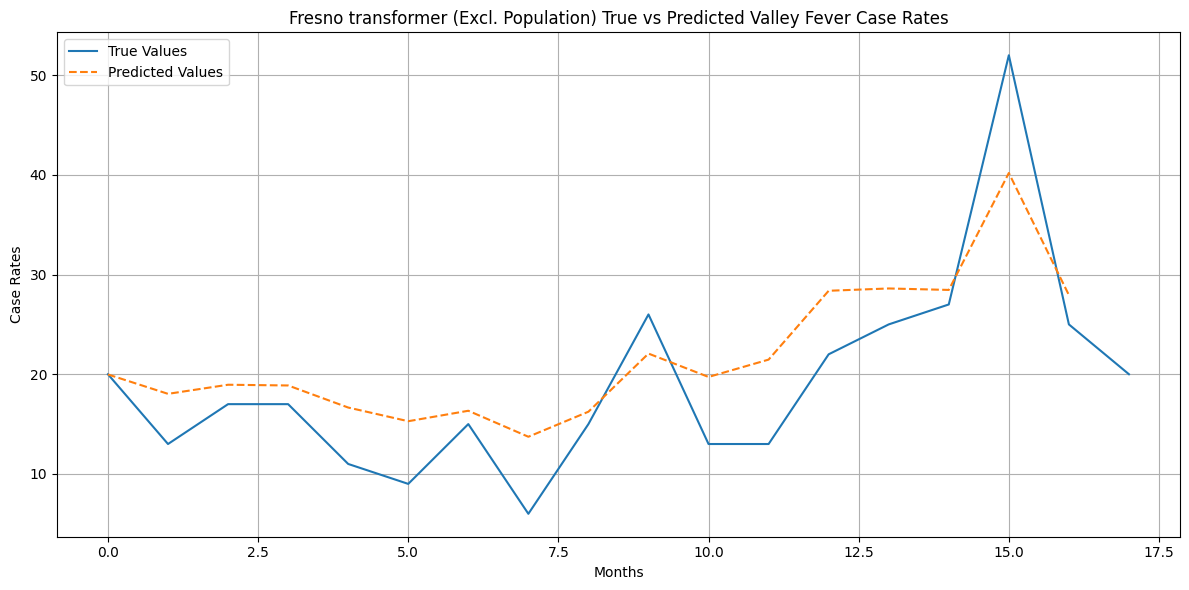

In [19]:
main(model_flag="transformer", county_name="Fresno", bAdd_Pop=False)

#### With Population Statistics Added

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4727, Testing Loss 0.0785
Epoch 11/300 - Training Loss 0.2824, Testing Loss 0.1132
Epoch 21/300 - Training Loss 0.2781, Testing Loss 0.2092
Epoch 31/300 - Training Loss 0.2241, Testing Loss 0.0821
Epoch 41/300 - Training Loss 0.1979, Testing Loss 0.1117
Epoch 51/300 - Training Loss 0.1915, Testing Loss 0.1230
Epoch 61/300 - Training Loss 0.1855, Testing Loss 0.0936
Epoch 71/300 - Training Loss 0.1667, Testing Loss 0.0908
Epoch 81/300 - Training Loss 0.1745, Testing Loss 0.0781
Epoch 91/300 - Training Loss 0.1565, Testing Loss 0.0775
Epoch 101/300 - Training Loss 0.1568, Testing Loss 0.0789
Epoch 111/300 - Training Loss 0.1560, Testing Loss 0.0765
Epoch 121/300 - Training Loss 0.1554, Testing Loss 0.0807
Epoch 131/300 - Training Loss 0.1618, Testing Loss 0.0757
Epoch 141/300 - Training Loss 0.1331, Testing Loss 0.0703
Epoch 151/300 - Training Loss 0.1343, Testing Loss 0.0722
Epoch 161/300 - Training Loss 0.1593, Testing Loss 0.0758
Epoch 171/300 - Training 

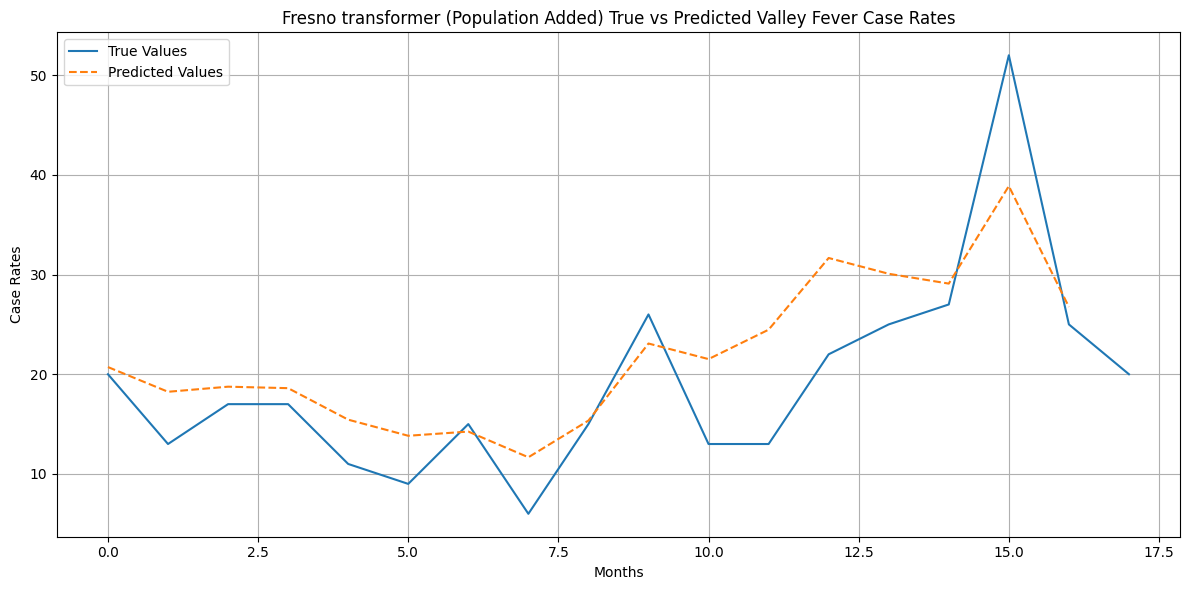

In [20]:
main(model_flag="transformer", county_name="Fresno", bAdd_Pop=True)

### Combination of Figures From Each Run

In [32]:
import matplotlib.pyplot as plt 

def model_comparison_subplots_by_county(county_name):
    model_flag_arr = ["lstm", "lstm", "transformer", "transformer"]
    bAdd_Pop_arr   = [False, True, False, True]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

    for i in range(4):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        # Get results from main
        y_true, y_pred = main(model_flag_arr[i], county_name, bAdd_Pop_arr[i], show_plot = False)

        # Plot
        ax.plot(y_true, label='True', linestyle='--')
        ax.plot(y_pred, label='Predicted', linestyle='-')
        ax.set_title(f"{model_flag_arr[i].upper()} | Pop: {bAdd_Pop_arr[i]}")
        ax.set_xlabel("Months")
        ax.set_ylabel("Valley Fever Case Count")
        ax.legend()

    plt.suptitle(f"Valley Fever Forecast for {county_name}", fontsize = 16)
    plt.tight_layout()
    plt.show()

#### Fresno County

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2925, Testing Loss 0.0816
Epoch 11/300 - Training Loss 0.2001, Testing Loss 0.2122
Epoch 21/300 - Training Loss 0.1974, Testing Loss 0.1872
Epoch 31/300 - Training Loss 0.1934, Testing Loss 0.1594
Epoch 41/300 - Training Loss 0.1868, Testing Loss 0.1794
Epoch 51/300 - Training Loss 0.1745, Testing Loss 0.1339
Epoch 61/300 - Training Loss 0.1621, Testing Loss 0.0846
Epoch 71/300 - Training Loss 0.1556, Testing Loss 0.0785
Epoch 81/300 - Training Loss 0.1439, Testing Loss 0.0921
Epoch 91/300 - Training Loss 0.1347, Testing Loss 0.0804
Epoch 101/300 - Training Loss 0.1218, Testing Loss 0.0954
Epoch 111/300 - Training Loss 0.1214, Testing Loss 0.0884
Epoch 121/300 - Training Loss 0.1179, Testing Loss 0.0871
Epoch 131/300 - Training Loss 0.1133, Testing Loss 0.0823
Epoch 141/300 - Training Loss 0.1134, Testing Loss 0.0818
Epoch 151/300 - Training Loss 0.1052, Testing Loss 0.0752
Epoch 161/300 - Training Loss 0.1033, Testing Loss 0.0833
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2747, Testing Loss 0.0812
Epoch 11/300 - Training Loss 0.1994, Testing Loss 0.2282
Epoch 21/300 - Training Loss 0.1924, Testing Loss 0.1571
Epoch 31/300 - Training Loss 0.1877, Testing Loss 0.1538
Epoch 41/300 - Training Loss 0.1787, Testing Loss 0.1268
Epoch 51/300 - Training Loss 0.1640, Testing Loss 0.0814
Epoch 61/300 - Training Loss 0.1582, Testing Loss 0.0632
Epoch 71/300 - Training Loss 0.1451, Testing Loss 0.0776
Epoch 81/300 - Training Loss 0.1328, Testing Loss 0.0748
Epoch 91/300 - Training Loss 0.1243, Testing Loss 0.0750
Epoch 101/300 - Training Loss 0.1208, Testing Loss 0.0783
Epoch 111/300 - Training Loss 0.1184, Testing Loss 0.0755
Epoch 121/300 - Training Loss 0.1106, Testing Loss 0.0833
Epoch 131/300 - Training Loss 0.1048, Testing Loss 0.0739
Epoch 141/300 - Training Loss 0.1080, Testing Loss 0.0760
Epoch 151/300 - Training Loss 0.1053, Testing Loss 0.0750
Epoch 161/300 - Training Loss 0.1030, Testing Loss 0.0772
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.8854, Testing Loss 0.5604
Epoch 11/300 - Training Loss 0.4025, Testing Loss 0.4294
Epoch 21/300 - Training Loss 0.2562, Testing Loss 0.0745
Epoch 31/300 - Training Loss 0.2755, Testing Loss 0.2437
Epoch 41/300 - Training Loss 0.2222, Testing Loss 0.1028
Epoch 51/300 - Training Loss 0.2020, Testing Loss 0.1301
Epoch 61/300 - Training Loss 0.1771, Testing Loss 0.1318
Epoch 71/300 - Training Loss 0.1695, Testing Loss 0.0820
Epoch 81/300 - Training Loss 0.1606, Testing Loss 0.0787
Epoch 91/300 - Training Loss 0.1472, Testing Loss 0.0811
Epoch 101/300 - Training Loss 0.1543, Testing Loss 0.0747
Epoch 111/300 - Training Loss 0.1629, Testing Loss 0.0740
Epoch 121/300 - Training Loss 0.1563, Testing Loss 0.0784
Epoch 131/300 - Training Loss 0.1401, Testing Loss 0.0762
Epoch 141/300 - Training Loss 0.1384, Testing Loss 0.0755
Epoch 151/300 - Training Loss 0.1390, Testing Loss 0.0752
Epoch 161/300 - Training Loss 0.1448, Testing Loss 0.0750
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 1.2116, Testing Loss 0.9238
Epoch 11/300 - Training Loss 0.4422, Testing Loss 0.5232
Epoch 21/300 - Training Loss 0.3959, Testing Loss 0.1200
Epoch 31/300 - Training Loss 0.2701, Testing Loss 0.2227
Epoch 41/300 - Training Loss 0.2707, Testing Loss 0.1916
Epoch 51/300 - Training Loss 0.2736, Testing Loss 0.2096
Epoch 61/300 - Training Loss 0.2049, Testing Loss 0.1750
Epoch 71/300 - Training Loss 0.2411, Testing Loss 0.1834
Epoch 81/300 - Training Loss 0.2094, Testing Loss 0.1706
Epoch 91/300 - Training Loss 0.1972, Testing Loss 0.1422
Epoch 101/300 - Training Loss 0.2014, Testing Loss 0.1131
Epoch 111/300 - Training Loss 0.1835, Testing Loss 0.0853
Epoch 121/300 - Training Loss 0.1876, Testing Loss 0.1048
Epoch 131/300 - Training Loss 0.1839, Testing Loss 0.0901
Epoch 141/300 - Training Loss 0.1532, Testing Loss 0.0863
Epoch 151/300 - Training Loss 0.1753, Testing Loss 0.0702
Epoch 161/300 - Training Loss 0.1561, Testing Loss 0.0707
Epoch 171/300 - Training 

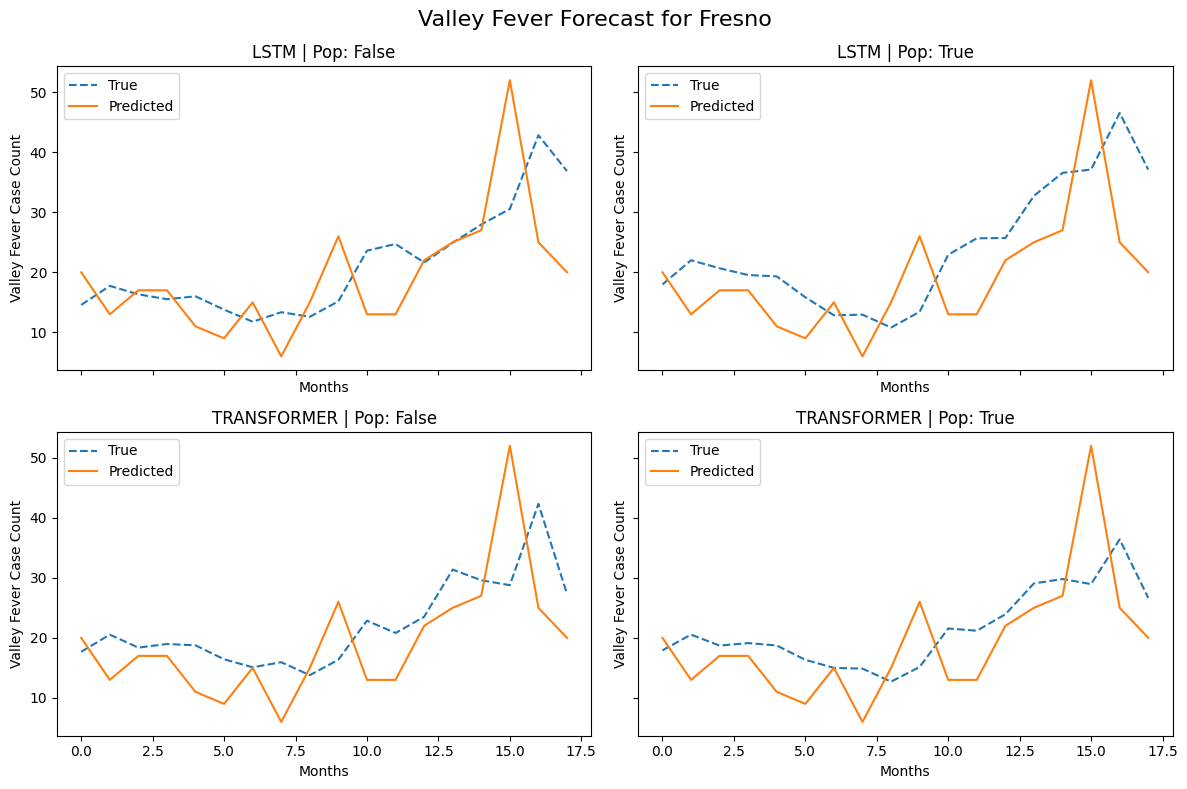

In [33]:
model_comparison_subplots_by_county("Fresno")

#### Tulare County

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4648, Testing Loss 0.2845
Epoch 11/300 - Training Loss 0.2499, Testing Loss 0.1189
Epoch 21/300 - Training Loss 0.2076, Testing Loss 0.2118
Epoch 31/300 - Training Loss 0.2012, Testing Loss 0.1441
Epoch 41/300 - Training Loss 0.1954, Testing Loss 0.2014
Epoch 51/300 - Training Loss 0.1934, Testing Loss 0.1640
Epoch 61/300 - Training Loss 0.1926, Testing Loss 0.1793
Epoch 71/300 - Training Loss 0.1913, Testing Loss 0.1693
Epoch 81/300 - Training Loss 0.1877, Testing Loss 0.1722
Epoch 91/300 - Training Loss 0.1852, Testing Loss 0.1659
Epoch 101/300 - Training Loss 0.1834, Testing Loss 0.1651
Epoch 111/300 - Training Loss 0.1838, Testing Loss 0.1611
Epoch 121/300 - Training Loss 0.1778, Testing Loss 0.1602
Epoch 131/300 - Training Loss 0.1744, Testing Loss 0.1585
Epoch 141/300 - Training Loss 0.1677, Testing Loss 0.1609
Epoch 151/300 - Training Loss 0.1655, Testing Loss 0.1666
Epoch 161/300 - Training Loss 0.1613, Testing Loss 0.1634
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4359, Testing Loss 0.2592
Epoch 11/300 - Training Loss 0.2317, Testing Loss 0.1372
Epoch 21/300 - Training Loss 0.2021, Testing Loss 0.2030
Epoch 31/300 - Training Loss 0.1993, Testing Loss 0.1487
Epoch 41/300 - Training Loss 0.1923, Testing Loss 0.1875
Epoch 51/300 - Training Loss 0.1844, Testing Loss 0.1442
Epoch 61/300 - Training Loss 0.1824, Testing Loss 0.1446
Epoch 71/300 - Training Loss 0.1823, Testing Loss 0.1257
Epoch 81/300 - Training Loss 0.1749, Testing Loss 0.1211
Epoch 91/300 - Training Loss 0.1738, Testing Loss 0.1222
Epoch 101/300 - Training Loss 0.1719, Testing Loss 0.1249
Epoch 111/300 - Training Loss 0.1595, Testing Loss 0.1272
Epoch 121/300 - Training Loss 0.1640, Testing Loss 0.1284
Epoch 131/300 - Training Loss 0.1574, Testing Loss 0.1298
Epoch 141/300 - Training Loss 0.1530, Testing Loss 0.1306
Epoch 151/300 - Training Loss 0.1576, Testing Loss 0.1307
Epoch 161/300 - Training Loss 0.1535, Testing Loss 0.1303
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.4865, Testing Loss 0.1680
Epoch 11/300 - Training Loss 0.3240, Testing Loss 0.1397
Epoch 21/300 - Training Loss 0.2613, Testing Loss 0.2014
Epoch 31/300 - Training Loss 0.2199, Testing Loss 0.1600
Epoch 41/300 - Training Loss 0.2102, Testing Loss 0.1659
Epoch 51/300 - Training Loss 0.2151, Testing Loss 0.1677
Epoch 61/300 - Training Loss 0.2133, Testing Loss 0.1657
Epoch 71/300 - Training Loss 0.1947, Testing Loss 0.1590
Epoch 81/300 - Training Loss 0.1892, Testing Loss 0.1641
Epoch 91/300 - Training Loss 0.1789, Testing Loss 0.1591
Epoch 101/300 - Training Loss 0.1663, Testing Loss 0.1669
Epoch 111/300 - Training Loss 0.1774, Testing Loss 0.1577
Epoch 121/300 - Training Loss 0.1735, Testing Loss 0.1646
Epoch 131/300 - Training Loss 0.1776, Testing Loss 0.1665
Epoch 141/300 - Training Loss 0.1661, Testing Loss 0.1653
Epoch 151/300 - Training Loss 0.1763, Testing Loss 0.1686
Epoch 161/300 - Training Loss 0.1812, Testing Loss 0.1707
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.6560, Testing Loss 0.3029
Epoch 11/300 - Training Loss 0.3552, Testing Loss 0.1323
Epoch 21/300 - Training Loss 0.2534, Testing Loss 0.1780
Epoch 31/300 - Training Loss 0.2248, Testing Loss 0.1330
Epoch 41/300 - Training Loss 0.2246, Testing Loss 0.1489
Epoch 51/300 - Training Loss 0.2144, Testing Loss 0.1519
Epoch 61/300 - Training Loss 0.2001, Testing Loss 0.1356
Epoch 71/300 - Training Loss 0.2136, Testing Loss 0.1549
Epoch 81/300 - Training Loss 0.1775, Testing Loss 0.1557
Epoch 91/300 - Training Loss 0.1934, Testing Loss 0.1419
Epoch 101/300 - Training Loss 0.1978, Testing Loss 0.1414
Epoch 111/300 - Training Loss 0.1812, Testing Loss 0.1484
Epoch 121/300 - Training Loss 0.1807, Testing Loss 0.1391
Epoch 131/300 - Training Loss 0.1809, Testing Loss 0.1334
Epoch 141/300 - Training Loss 0.1836, Testing Loss 0.1386
Epoch 151/300 - Training Loss 0.1825, Testing Loss 0.1386
Epoch 161/300 - Training Loss 0.1851, Testing Loss 0.1365
Epoch 171/300 - Training 

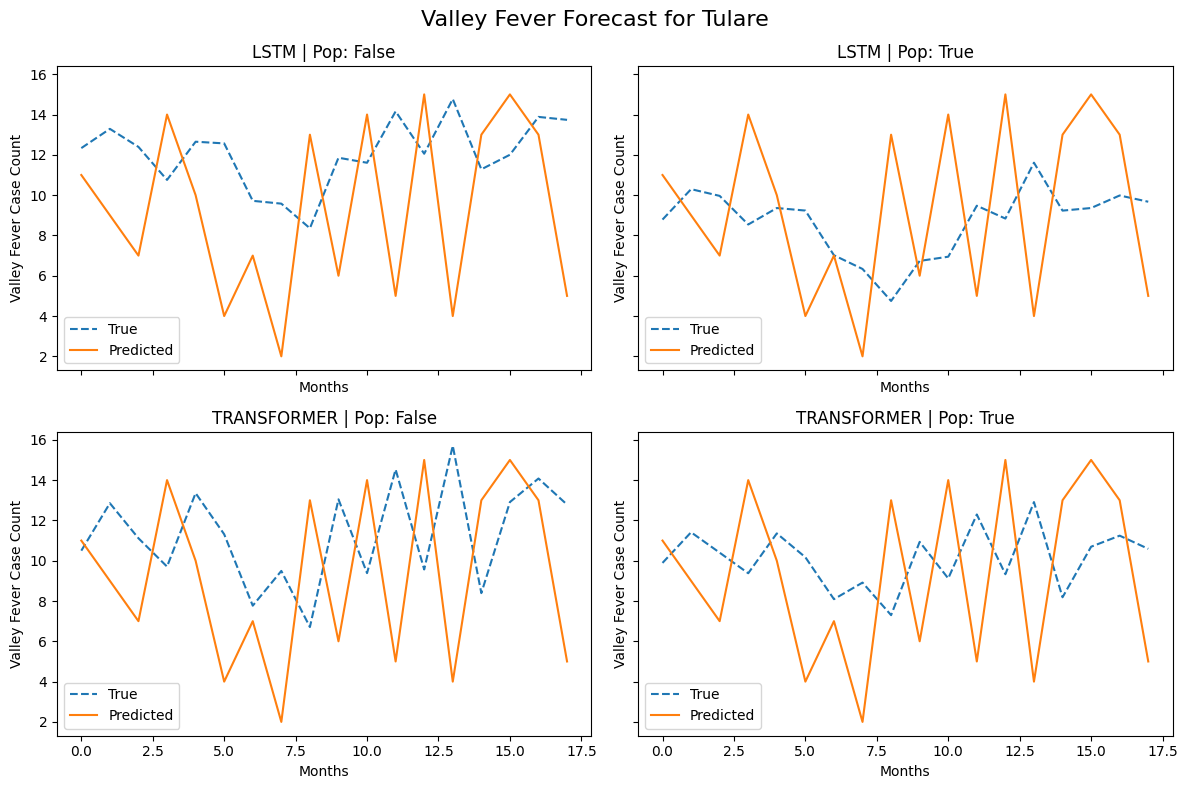

In [34]:
model_comparison_subplots_by_county("Tulare")

#### Kern County

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2356, Testing Loss 0.0894
Epoch 11/300 - Training Loss 0.1838, Testing Loss 0.1644
Epoch 21/300 - Training Loss 0.1743, Testing Loss 0.1044
Epoch 31/300 - Training Loss 0.1671, Testing Loss 0.1165
Epoch 41/300 - Training Loss 0.1582, Testing Loss 0.0892
Epoch 51/300 - Training Loss 0.1515, Testing Loss 0.0762
Epoch 61/300 - Training Loss 0.1466, Testing Loss 0.0764
Epoch 71/300 - Training Loss 0.1431, Testing Loss 0.0750
Epoch 81/300 - Training Loss 0.1341, Testing Loss 0.0672
Epoch 91/300 - Training Loss 0.1253, Testing Loss 0.0613
Epoch 101/300 - Training Loss 0.1178, Testing Loss 0.0549
Epoch 111/300 - Training Loss 0.1102, Testing Loss 0.0510
Epoch 121/300 - Training Loss 0.1123, Testing Loss 0.0462
Epoch 131/300 - Training Loss 0.1018, Testing Loss 0.0433
Epoch 141/300 - Training Loss 0.0977, Testing Loss 0.0423
Epoch 151/300 - Training Loss 0.0947, Testing Loss 0.0434
Epoch 161/300 - Training Loss 0.0958, Testing Loss 0.0397
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.2386, Testing Loss 0.0927
Epoch 11/300 - Training Loss 0.1834, Testing Loss 0.1760
Epoch 21/300 - Training Loss 0.1751, Testing Loss 0.1096
Epoch 31/300 - Training Loss 0.1691, Testing Loss 0.1461
Epoch 41/300 - Training Loss 0.1609, Testing Loss 0.1258
Epoch 51/300 - Training Loss 0.1527, Testing Loss 0.1252
Epoch 61/300 - Training Loss 0.1494, Testing Loss 0.1093
Epoch 71/300 - Training Loss 0.1430, Testing Loss 0.1015
Epoch 81/300 - Training Loss 0.1380, Testing Loss 0.0892
Epoch 91/300 - Training Loss 0.1342, Testing Loss 0.0865
Epoch 101/300 - Training Loss 0.1201, Testing Loss 0.0811
Epoch 111/300 - Training Loss 0.1111, Testing Loss 0.0864
Epoch 121/300 - Training Loss 0.1101, Testing Loss 0.0633
Epoch 131/300 - Training Loss 0.1060, Testing Loss 0.0537
Epoch 141/300 - Training Loss 0.1004, Testing Loss 0.0602
Epoch 151/300 - Training Loss 0.1004, Testing Loss 0.0483
Epoch 161/300 - Training Loss 0.1020, Testing Loss 0.0602
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 1.0709, Testing Loss 0.7609
Epoch 11/300 - Training Loss 0.3996, Testing Loss 0.4839
Epoch 21/300 - Training Loss 0.3177, Testing Loss 0.0941
Epoch 31/300 - Training Loss 0.2267, Testing Loss 0.1721
Epoch 41/300 - Training Loss 0.2243, Testing Loss 0.0929
Epoch 51/300 - Training Loss 0.1989, Testing Loss 0.1130
Epoch 61/300 - Training Loss 0.1909, Testing Loss 0.0701
Epoch 71/300 - Training Loss 0.1836, Testing Loss 0.0570
Epoch 81/300 - Training Loss 0.1631, Testing Loss 0.0552
Epoch 91/300 - Training Loss 0.1593, Testing Loss 0.0499
Epoch 101/300 - Training Loss 0.1639, Testing Loss 0.0459
Epoch 111/300 - Training Loss 0.1540, Testing Loss 0.0495
Epoch 121/300 - Training Loss 0.1542, Testing Loss 0.0459
Epoch 131/300 - Training Loss 0.1562, Testing Loss 0.0441
Epoch 141/300 - Training Loss 0.1457, Testing Loss 0.0437
Epoch 151/300 - Training Loss 0.1307, Testing Loss 0.0501
Epoch 161/300 - Training Loss 0.1261, Testing Loss 0.0531
Epoch 171/300 - Training 

/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fire_monthly = fire_county.resample("M").size()
/Users/dballen/Documents/GitHub/CSUF-Project-Code/Project/code/data_loader.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_months = pd.date_range("2006-01-01", "2018-12-31", freq="M")


Epoch 1/300 - Training Loss 0.7095, Testing Loss 0.1752
Epoch 11/300 - Training Loss 0.3683, Testing Loss 0.2533
Epoch 21/300 - Training Loss 0.2667, Testing Loss 0.2103
Epoch 31/300 - Training Loss 0.2293, Testing Loss 0.1505
Epoch 41/300 - Training Loss 0.1995, Testing Loss 0.2123
Epoch 51/300 - Training Loss 0.1879, Testing Loss 0.1760
Epoch 61/300 - Training Loss 0.1841, Testing Loss 0.1688
Epoch 71/300 - Training Loss 0.1911, Testing Loss 0.1552
Epoch 81/300 - Training Loss 0.1854, Testing Loss 0.1590
Epoch 91/300 - Training Loss 0.1585, Testing Loss 0.1629
Epoch 101/300 - Training Loss 0.1639, Testing Loss 0.1549
Epoch 111/300 - Training Loss 0.1471, Testing Loss 0.1370
Epoch 121/300 - Training Loss 0.1541, Testing Loss 0.1287
Epoch 131/300 - Training Loss 0.1573, Testing Loss 0.1064
Epoch 141/300 - Training Loss 0.1524, Testing Loss 0.1096
Epoch 151/300 - Training Loss 0.1475, Testing Loss 0.1126
Epoch 161/300 - Training Loss 0.1454, Testing Loss 0.1113
Epoch 171/300 - Training 

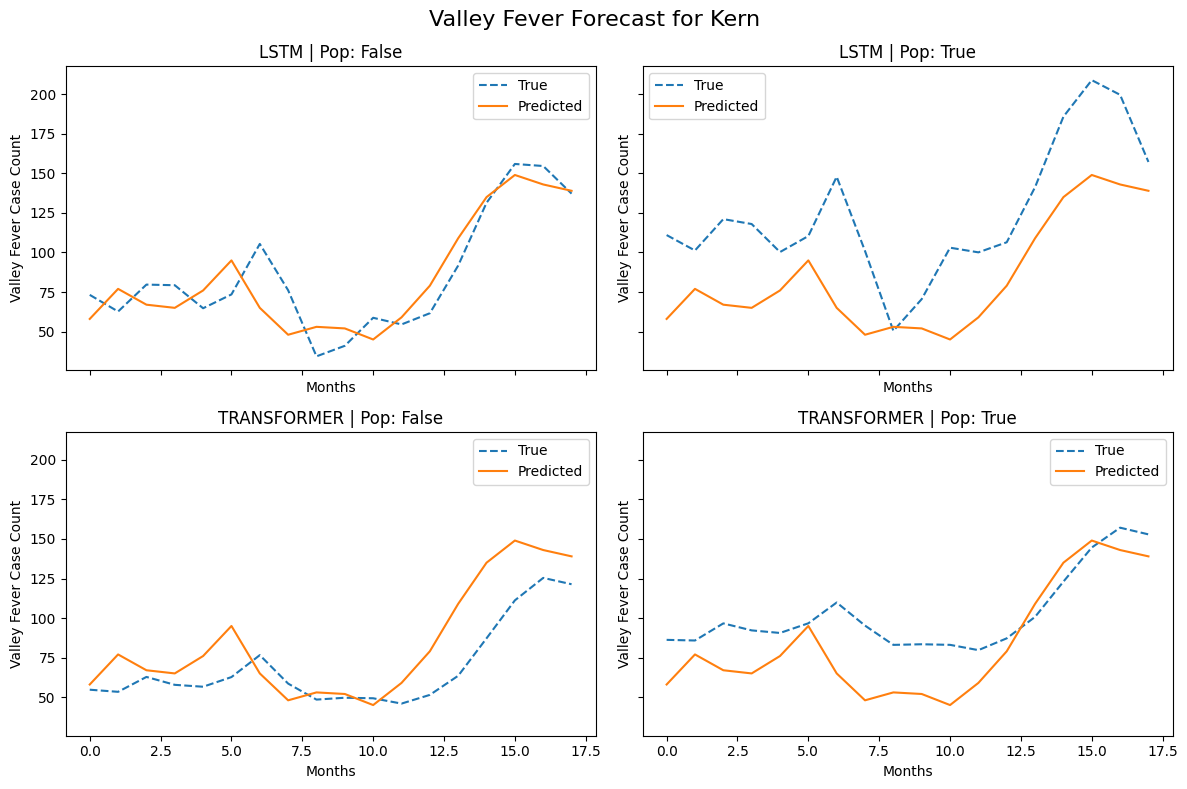

In [35]:
model_comparison_subplots_by_county("Kern")

## SandBox

Random area in case we want to play with code or model parameters